In [1135]:
import os
import numpy as np
from plot_params import *
from scipy.spatial.distance import cdist
from copy import deepcopy
from tqdm import tqdm
from joblib import Parallel, delayed

In [1136]:
def total_energy(pos):
    dist = cdist(pos, pos)
    li = np.tril_indices(len(pos), k=-1)
    pair_dist = dist[li]
    total_energy = (1 / pair_dist).sum()
    return total_energy


def accept_move(T, energy_after, energy_before):
    delta_energy = energy_after - energy_before
    if delta_energy < 0:
        return True
    p = np.exp(- delta_energy / T)
    if np.random.rand() <= p:
        return True
    return False


def random_move(pos, i):
    og = deepcopy(pos)
    move = np.random.uniform(-1, 1, 2)
    normal_move = move / np.linalg.norm(move)
    pos[i] = og[i] + normal_move * stepsize
    if np.sqrt(pos[i][0] ** 2 + pos[i][1] ** 2) < circle_radius:
        return pos
    return og


def run():
    # initialize particles
    r = np.random.rand(n)
    theta = np.random.rand(n) * 2 * np.pi
    x = np.cos(theta) * r
    y = np.sin(theta) * r
    pos = np.stack((x, y), axis=1)

    # loop temp
    for j in tqdm(range(steps)):
        # loop charge
        for i in range(n):
            energy_before = total_energy(pos)
            # possible_pos = random_move(deepcopy(pos), i)
            possible_pos = random_move_with_drift(deepcopy(pos), i)
            energy_after = total_energy(possible_pos)
            if accept_move(T[j], energy_after, energy_before):
                pos = possible_pos
    return pos


def random_move_with_drift(pos, i):
    og = deepcopy(pos)

    # calc force
    r = cdist(pos, pos)
    r = r[i]
    r = r[r != 0]

    r_x = pos[:, 0].reshape(-1 , 1) - pos[:, 0]
    r_x = r_x[i]
    r_x = r_x[r_x != 0]

    r_y = pos[:, 1].reshape(-1 , 1) - pos[:, 1]
    r_y = r_y[i]
    r_y = r_y[r_y != 0]

    force = np.stack((r_x / np.abs(r ** 3), r_y / np.abs(r ** 3)), axis=1)
    total_force = force.sum(axis=0)

    normal_force_move = total_force / np.linalg.norm(total_force)

    # calc random
    random_move = np.random.uniform(-1, 1, 2)
    normal_random_move = random_move / np.linalg.norm(random_move)

    # add together
    pos[i] = og[i] + (normal_random_move + normal_force_move) * stepsize
    if np.sqrt(pos[i][0] ** 2 + pos[i][1] ** 2) < circle_radius:
        return pos
    return og

In [1137]:
# settings
steps = 50
stepsize = 0.05
n = 11
runs = 500
circle_radius = 1
cpu_count = os.cpu_count()

# temp function
i = np.linspace(10, 1, steps)
B = 7
vu = 4
M = 6
T = 1 / (1 + np.exp(- B * (i - M)) ** (1 / vu)) # logistic because cool

# run 
results = Parallel(n_jobs=cpu_count, verbose=1)(delayed(run)() for _ in range(runs))
results = np.array(results)

quality = []
for r in results:
    q = total_energy(r)
    quality.append(q)
best = results[np.argmin(quality)]
worst = results[np.argmax(quality)]

# # save
# np.save(f'{runs}times{n}.npy', results)

[Parallel(n_jobs=12)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.6s
[Parallel(n_jobs=12)]: Done 176 tasks      | elapsed:    3.5s
[Parallel(n_jobs=12)]: Done 426 tasks      | elapsed:    8.7s
[Parallel(n_jobs=12)]: Done 500 out of 500 | elapsed:   10.1s finished


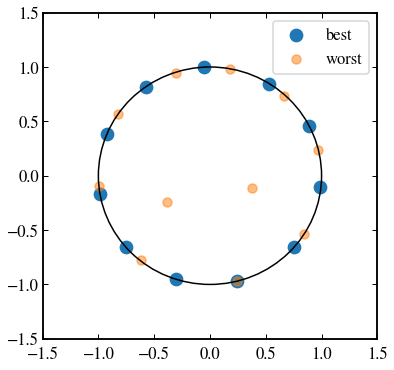

In [1138]:
# plot best and worst outcome
plt.figure(figsize=(6, 6))
plt.scatter(best[:, 0], best[:, 1], label='best', s=150)
plt.scatter(worst[:, 0], worst[:, 1], label='worst', alpha=0.5)
plt.legend()
plt.xlim(-1.5, 1.5)
plt.ylim(-1.5, 1.5)
circle = plt.Circle((0, 0), 1, fill=False)
plt.gca().add_patch(circle)
plt.show()

In [1139]:
# i = np.linspace(10, 1, steps)
# B = 7
# vu = 4
# M = 6
# T = 1 / (1 + np.exp(- B * (i - M)) ** (1 / vu))

# plt.plot(i, T)
